# Testing out loss functions

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from glob import glob
import json
import matplotlib.pyplot as plt

import math

import networkx as nx

from preprocess import getNumPairs, scale, transformData, prepareData
from trainNet import getGNNDataLoaders, pairAGraph, check_accuracy

import os
os.sys.path.append('../code')
from analysis import normalizeWeight

%load_ext autoreload
%autoreload 2

In [2]:
x_start, x_end = 0,1
x = np.linspace(-0.1,1.5)
f = lambda x: np.exp(x)
y = f(x)
z = ((f(x_end) - f(x_start))/(x_end - x_start))*x + f(x_start)

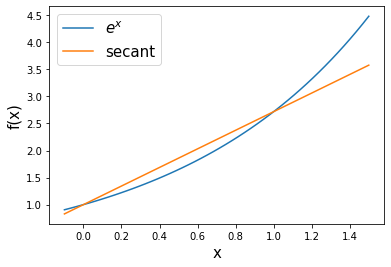

In [16]:
plt.plot(x,y,label='$e^x$')
plt.plot(x,z,label='secant')
plt.xlabel('x',fontsize=15)
plt.ylabel('f(x)',fontsize=15)
plt.legend(fontsize=15)
plt.savefig('figures/JensensEquality.pdf')
plt.show()

So if I take the score to be the similarity function, then for a pairing
- HC1: $j_i$, $j_j$
- HC2: $j_k$, $j_l$
I don't think when considering an ensemble over pairing minimizizing $(j_i - j_j)^2 + (j_k - j_l)^2$ is equivalent to maximizing $\exp\left(-\frac{1}{2}(j_i - j_j)^2\right) + \exp\left(-\frac{1}{2}(j_k - j_l)^2\right)$?

I don't think so

*Can I find a counter-example?*

In reality, I think this just corresponds to a *different similarity metric* and I believe the way to find the best similarity metric is to just test several out!

### Finish the pre-processing!!

In [3]:
reload = True

physicsSample = 'SMNR'
nSelectedJets = 5
prodTag = 'MAR2020'

fName = "/df_3b.h5"

In [4]:
# I don't want all the columns... so just load a few
jetVars = ['pt','eta','phi','E','Db']
loadCols = ['j{}_{}'.format(i,v) for i in range(nSelectedJets) for v in jetVars]
loadCols += ['mc_sf','njets','nbtags','correctPair','selJet_correctPair','eventNumber','runNumber']

In [20]:
# if reload:

#     for mc in ['mc16a','mc16d','mc16e']:
    
#         subDir = f'{physicsSample}_{mc}_PFlow-{prodTag}-{nSelectedJets}jets'
#         print("Processing",subDir)
        
#         dfs = []
#         myFile = '../data/' + subDir + fName

#         dfi = pd.read_hdf(myFile,key='df')
#         loadMask = (dfi.njets >= 4) & (dfi.ntag >= 3)
#         dfs.append(dfi[loadMask])
            
#     df = pd.concat(dfs)


Processing SMNR_mc16a_PFlow-MAR2020-5jets
Processing SMNR_mc16d_PFlow-MAR2020-5jets
Processing SMNR_mc16e_PFlow-MAR2020-5jets


Do the normalization - and make pretty plots!!

In [33]:
np.min(df[[f'j{i}_Db' for i in range(5)]])

j0_Db    1
j1_Db    1
j2_Db    1
j3_Db    1
j4_Db    0
dtype: int64

(array([ 597102.,   75503.,  178477.,  243436., 1352328.]),
 array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 <a list of 5 Patch objects>)

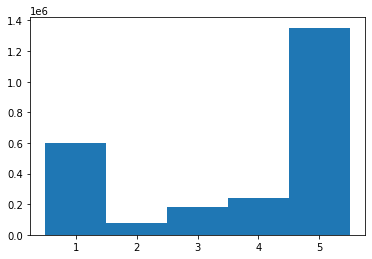

In [47]:
dfa = pd.read_hdf('../data/SMNR_mc16e_PFlow-MAR2020-5jets/df_3b_scaledInputs.h5',key='df')
ma = ~(dfa[[f'j{i}_Db' for i in range(5)]]==0).values

plt.hist(dfa[[f'j{i}_Db' for i in range(5)]].values[ma],5,(.5,5.5))

Scaling pt.
Scaling E.


/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block5_values] [items->Index(['HLT_2j35_bmv2c2060_split_2j35_L14J15.0ETA25',
       'HLT_j100_2j55_bmv2c2060_split', 'HLT_j225_bmv2c2060_split',
       'HLT_2j15_gsc35_bmv2c1040_split_2j15_gsc35_boffperf_split_L14J15.0ETA25',
       'HLT_2j35_gsc55_bmv2c1050_split_ht300_L1HT190-J15s5.ETA21',
       'HLT_j110_gsc150_boffperf_split_2j35_gsc55_bmv2c1070_split_L1J85_3J30',
       'HLT_j225_gsc300_bmv2c1070_split',
       'HLT_j35_gsc55_bmv2c1050_split_ht700_L1HT190-J15s5.ETA21',
       'HLT_2j45_gsc55_bmv2c1050_split_ht300_L1HT190-J15s5.ETA21',
       'HLT_2j35_bmv2c1060_split_2j35_L14J15.0ETA25',
       'HLT_j110_gsc150_boffperf_split_2j45_gsc55_bmv2c1070_split_L1J85_3J30'],
      dtype='object')]

  encoding=encoding,


Scaling pt.
Scaling E.
Saving  ../data/SMNR_mc16a_PFlow-MAR2020-5jets/df_3b_scaledInputs.h5
Scaling pt.
Scaling E.
Saving  ../data/SMNR_mc16d_PFlow-MAR2020-5jets/df_3b_scaledInputs.h5
Scaling pt.
Scaling E.
Saving  ../data/SMNR_mc16e_PFlow-MAR2020-5jets/df_3b_scaledInputs.h5


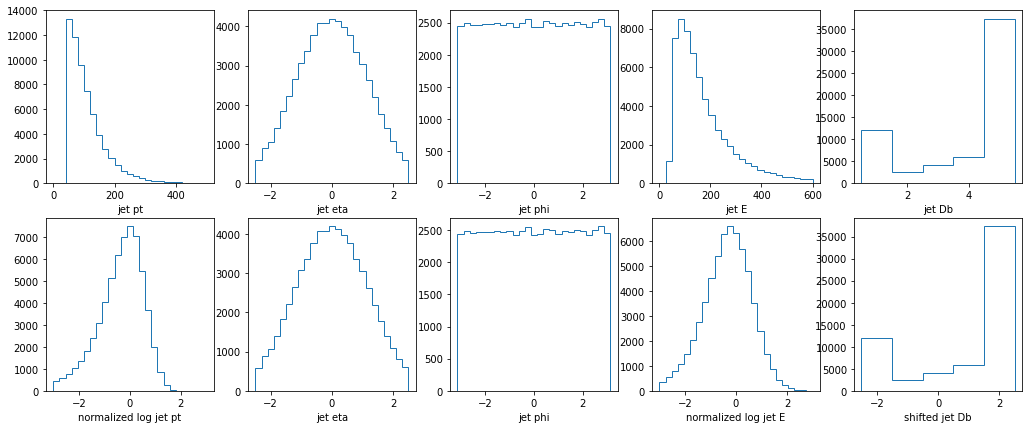

In [50]:
prepareData(prodTag=prodTag)

In [54]:
loader_train, loader_val = getGNNDataLoaders(2048,nSelectedJets=nSelectedJets,prodTag=prodTag)

352047  train + val events


In [4]:
for i0 in range(nSelectedJets-3):
    for i1 in range(i0+1,nSelectedJets-2):
        for i2 in range(i1+1,nSelectedJets-1): 
            for i3 in range(i2+1,nSelectedJets):
                for (h11,h12), (h21, h22) in zip([(i0,i1),(i0,i2),(i0,i3)],[(i2,i3),(i1,i3),(i1,i2)]):
                    print(f'h1: ({h11},{h12}), h2: ({h21}, {h22})')

h1: (0,1), h2: (2, 3)
h1: (0,2), h2: (1, 3)
h1: (0,3), h2: (1, 2)
h1: (0,1), h2: (2, 4)
h1: (0,2), h2: (1, 4)
h1: (0,4), h2: (1, 2)
h1: (0,1), h2: (3, 4)
h1: (0,3), h2: (1, 4)
h1: (0,4), h2: (1, 3)
h1: (0,2), h2: (3, 4)
h1: (0,3), h2: (2, 4)
h1: (0,4), h2: (2, 3)
h1: (1,2), h2: (3, 4)
h1: (1,3), h2: (2, 4)
h1: (1,4), h2: (2, 3)


In [5]:
from itertools import combinations

In [7]:
for i0,i1,i2,i3 in combinations(range(nSelectedJets),4):
    for (h11,h12), (h21, h22) in zip([(i0,i1),(i0,i2),(i0,i3)],[(i2,i3),(i1,i3),(i1,i2)]):
            print(f'h1: ({h11},{h12}), h2: ({h21}, {h22})')

h1: (0,1), h2: (2, 3)
h1: (0,2), h2: (1, 3)
h1: (0,3), h2: (1, 2)
h1: (0,1), h2: (2, 4)
h1: (0,2), h2: (1, 4)
h1: (0,4), h2: (1, 2)
h1: (0,1), h2: (3, 4)
h1: (0,3), h2: (1, 4)
h1: (0,4), h2: (1, 3)
h1: (0,2), h2: (3, 4)
h1: (0,3), h2: (2, 4)
h1: (0,4), h2: (2, 3)
h1: (1,2), h2: (3, 4)
h1: (1,3), h2: (2, 4)
h1: (1,4), h2: (2, 3)


### Load in the trained models for the two loss functions

In [ ]:
modelDir = f"models/{physicsSample}_mc16ade_PFlow-{prodTag}-{nSelectedJets}jets/xformer_{nLayers}layers_dim{embed_dim}_ff{ff_dim}_{nHeads}heads_dpt{dpt}_lr{lr}_batch2048"
model.load_state_dict(torch.load(f'{modelDir}/model.pt'))
model.eval()

### Evaluate the performance

In [6]:
subDir = 'SMNR_mc16a_PFlow-MAR2020-5jets'

In [7]:
df = pd.read_hdf(f"../data/{subDir}/df_3b_scaledInputs.h5", key='df')
df = df[df.index % 2 == 0]

In [8]:
df.head()

eventNumber  nresolvedJets  resolved_nBTags  mcEventWeight  \
entry                                                               
0              442              4                3       0.120290   
2             1088              6                4       0.037104   
14            1974              6                3       0.116338   
22            1823              6                3       0.083696   
24            1931              7                3      -0.085212   

       weight_pileup  rand_run_nr       j0_pt    j0_eta    j0_phi        j0_E  \
entry                                                                           
0           0.832972       310863   65.844810  0.146446  2.467891   67.811531   
2           0.913518       307619  141.734589 -1.114459  0.415969  240.037628   
14          1.124388       303421   95.889526 -1.953326  2.524543  345.063019   
22          0.913518       311321  332.366669  0.302779  1.854437  348.910309   
24          0.874238       304198  209.542023 -0.134799 -1.734556  213.012665   

       ...   ml_j0_E   ml_j1_E   ml_j2_E   ml_j3_E   ml_j4_E  ml_j0_Db  \
entry  ...                                                               
0      ... -0.687443  0.121061  0.740119 -0.675361  0.000000       3.5   
2      ...  0.529204 -0.115811  0.255826 -0.265312 -0.091691       3.5   
14     ...  0.878522  0.217350 -0.302329 -0.799606 -1.023935       3.5   
22     ...  0.889194  1.155624  0.893902  0.104622 -1.135157       3.5   
24     ...  0.414240  0.711263  0.437440 -0.486216 -0.862263       3.5   

       ml_j1_Db  ml_j2_Db  ml_j3_Db  ml_j4_Db  
entry                                          
0           3.5       3.5       3.5       0.0  
2           3.5       3.5       3.5       3.5  
14          3.5       3.5       3.5       3.5  
22          3.5       3.5       3.5       3.5  
24          3.5       3.5       3.5       3.5  

[5 rows x 125 columns]

In [9]:
# Since I'm only using half the stats for the test set, need to multiply L by 2.
L = 24.5556
key = subDir[:-6]
print(key)
normalizeWeight(df,key,lumi=L*2)

X_test = np.dstack([df[['ml_j{}_{}'.format(i,v) for i in range(nSelectedJets)]].values for v in jetVars])
njets = np.sum(~ np.all(X_test==0, axis=-1),axis=1) 

# Get the mask for the scores
ttlPairs = getNumPairs(nSelectedJets)
scoreMask = np.ones((X_test.shape[0],ttlPairs)).astype(bool)

for ji in range(4,nSelectedJets):
    nPairs = getNumPairs(ji)
    scoreMask[njets==ji] *= np.array([True]*nPairs + [False]*(ttlPairs-nPairs))
    
# Make them pytorch tensors
X_test = torch.tensor(X_test).float().to(device)
scoreMask = torch.tensor(scoreMask).to(device)

SMNR_mc16a_PFlow-MAR2020


KeyError: 'SMNR_mc16a_PFlow-MAR2020'

In [10]:
model.to(device)
model.eval()

logits, edgeWeights = model(X_test)

logits[~scoreMask] = float('-inf') # 0
_, y_pred = torch.max(logits,1)

y_pred = y_pred.cpu().numpy()
edgeWeights = edgeWeights.cpu().detach().numpy()

NameError: name 'model' is not defined